## Семинар 9
# Тема: Многомерные методы импутации пропусков

#### Многомерные способы импутации пропущенных значений

Многомерные способы импутации пропусков - это замещение пропусков в каждом признаке, используя данные из других признаков тоже, а не только того признака, в котором осуществляется импутация. Другими словами, мы строим модель машинного обучения для заполнения пропусков.Такой моделью может быть линейная регрессия для количественных признаков или логистическая регрессия для категориальных. Обратите внимание, что хотя технически мы могли бы использовать исходную целевую переменную в качестве одного из признаков для заполнения пропусков, делать этого не стоит, потому что в этом случае мы создадим между ними взаимосвязь, которой изначально могло не быть.

Импортируем необходимые библиотеки:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### 1. Загрузите датасет `Titanic.csv`. Выведите размеры загруженного датафрейма и информацию о данных.

In [3]:
df = pd.read_csv('Titanic.csv') 

In [4]:
df.shape

(891, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2. Удалите из загруженного датафрейма целевую переменную Survived.

In [6]:
df = df.drop(columns=['Survived'])

In [7]:
df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### 3. Замените значения в признаке 'Sex' в соответствии со словарём {'male': 1, 'female': 0}. Оставьте в датафрейме только числовые признаки и выведите первые 3 строки.

In [8]:
sex_map = {'male': 1, 'female': 0}
df['Sex'] = df['Sex'].map(sex_map)
df_numeric = df.select_dtypes(include=['number'])

In [9]:
df_numeric.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,3,1,22.0,1,0,7.2500
1,2,1,0,38.0,1,0,71.2833
2,3,3,0,26.0,0,0,7.9250


### 4. Убедитесь, что единственный признак, в котором есть пропуски - это Age.

In [10]:
missing_values = df_numeric.isnull().sum()

In [11]:
missing_values

PassengerId      0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64

### 5. Произведите масштабирование данных, выполнив стандартную нормализацию. Представьте результат в виде датафрейма  df_scaled, добавив названия колонок.

In [12]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(scaled_array, columns=df_numeric.columns)

In [13]:
df_scaled.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,-1.730108,0.827377,0.737695,-0.530377,0.432793,-0.473674,-0.502445
1,-1.726220,-1.566107,-1.355574,0.571831,0.432793,-0.473674,0.786845
2,-1.722332,0.827377,-1.355574,-0.254825,-0.474545,-0.473674,-0.488854


### 6. Из этого датафрейма выделите датафрейм, состоящий из строк, в которых в столбце Age стоят пропуски, создайте его копию и обозначьте её за Test. Удалите из датафрейма Test столбец Age и обозначьте полученный датафрейм X_test.

In [14]:
Test = df[df['Age'].isnull()].copy()
X_test = Test.drop(columns=['Age'])

In [15]:
X_test.shape

(177, 10)

In [16]:
Test.shape

(177, 11)

### 7. Из датафрейма df_scaled и с помощью метода .dropna() удалите все строки с пропусками, создайте его копию и обозначьте полученный датафрейм Train. Из него выделите столбец Age, это будет целевая переменная, обозначьте её y_train. Удалите из датафрейма Train столбец Age и обозначьте полученный датафрейм X_train.

In [17]:
Train = df_scaled.dropna().copy()
y_train = Train['Age']
X_train = Train.drop(columns=['Age'])

In [18]:
Train.shape

(714, 7)

In [19]:
X_train.shape

(714, 6)

In [20]:
y_train.shape

(714,)

### 8. Выведите размеры X_train, X_test и y_train. Убедитесь, что в сумме размеры X_train и X_test будут равны общему количеству наблюдений в исходном датафрейме.

In [21]:
cols = ['Name', 'Ticket', 'Cabin', 'Embarked']
X_test = X_test.drop(columns=cols)

In [22]:
X_train.shape

(714, 6)

In [23]:
X_test.shape

(177, 6)

In [24]:
y_train.shape

(714,)

In [25]:
total_rows = df.shape[0]
sum_train_test = X_train.shape[0] + X_test.shape[0]

In [26]:
total_rows

891

In [27]:
sum_train_test

891

In [28]:
total_rows == sum_train_test

True

### 9. Обучите модель линейной регрессии на обучающих данных и сделайте предсказание на тестовых данных.

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
y_pred = model.predict(X_test)
y_pred[:5]

array([-1.65179297, -1.52731412, -1.68369084, -1.57737508, -1.72430862])

### 10. Заполните этими предсказанными значениями столбец Age в датафрейме Test.

In [31]:
df.loc[df['Age'].isnull(), 'Age'] = y_pred

### 11. Соедините датафреймы Train и Test в один при помощи метода .concat(). Восстановите исходный порядок строк в нём, отсортировав их по индексу. Выведите первые 10 строк полученного датафрейма. 

In [32]:
Test = Test.drop(columns=cols)

In [33]:
combined = pd.concat([Train, Test])
combined = combined.sort_index()

In [34]:
print(combined.head(10))

   PassengerId    Pclass       Sex       Age     SibSp     Parch      Fare
0    -1.730108  0.827377  0.737695 -0.530377  0.432793 -0.473674 -0.502445
1    -1.726220 -1.566107 -1.355574  0.571831  0.432793 -0.473674  0.786845
2    -1.722332  0.827377 -1.355574 -0.254825 -0.474545 -0.473674 -0.488854
3    -1.718444 -1.566107 -1.355574  0.365167  0.432793 -0.473674  0.420730
4    -1.714556  0.827377  0.737695  0.365167 -0.474545 -0.473674 -0.486337
5     6.000000  3.000000  1.000000       NaN  0.000000  0.000000  8.458300
6    -1.706781 -1.566107  0.737695  1.674039 -0.474545 -0.473674  0.395814
7    -1.702893  0.827377  0.737695 -1.908136  2.247470  0.767630 -0.224083
8    -1.699005  0.827377 -1.355574 -0.185937 -0.474545  2.008933 -0.424256
9    -1.695117 -0.369365 -1.355574 -1.081480  0.432793 -0.473674 -0.042956


### 12. Верните данным исходный масштаб при помощи метода .inverse_transform(). Убедитесь, что пропусков в данных больше нет.

In [35]:
combined_original_scale_array = scaler.inverse_transform(combined)
combined_original_scale = pd.DataFrame(combined_original_scale_array, 
                                       columns=combined.columns, 
                                       index=combined.index)
missing_values = combined_original_scale.isnull().sum()

In [36]:
missing_values

PassengerId      0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64

### 13.  Выведите уникальные значения по возрастанию для признака Age. Округлите данные в столбце Age до одного знака после запятой. Все значения меньшие или равные 0,5 в признаке Age замените на это число при помощи метода .clip().

In [37]:
combined_original_scale['Age'] = combined_original_scale['Age'].round(1)
combined_original_scale['Age'] = combined_original_scale['Age'].clip(lower=0.5)
unique_ages = sorted(combined_original_scale['Age'].unique())

In [38]:
print(unique_ages)

[0.8, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 11.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 28.5, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 38.0, nan, 0.5, 0.7, 0.9, 1.0, 6.0, 9.0, 10.0, 12.0, 13.0, 14.5, 20.5, 23.5, 24.5, 30.5, 32.5, 34.5, 36.0, 36.5, 37.0, 39.0, 40.0, 40.5, 41.0, 42.0, 43.0, 44.0, 45.0, 45.5, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 55.5, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 70.0, 70.5, 71.0, 74.0, 80.0]


### 14. Постройте гистограммы распределения признака Age до заполнения пропусков и после. Выведите среднее и медианное значения для признака Age до заполнения пропусков и после, сравните их.

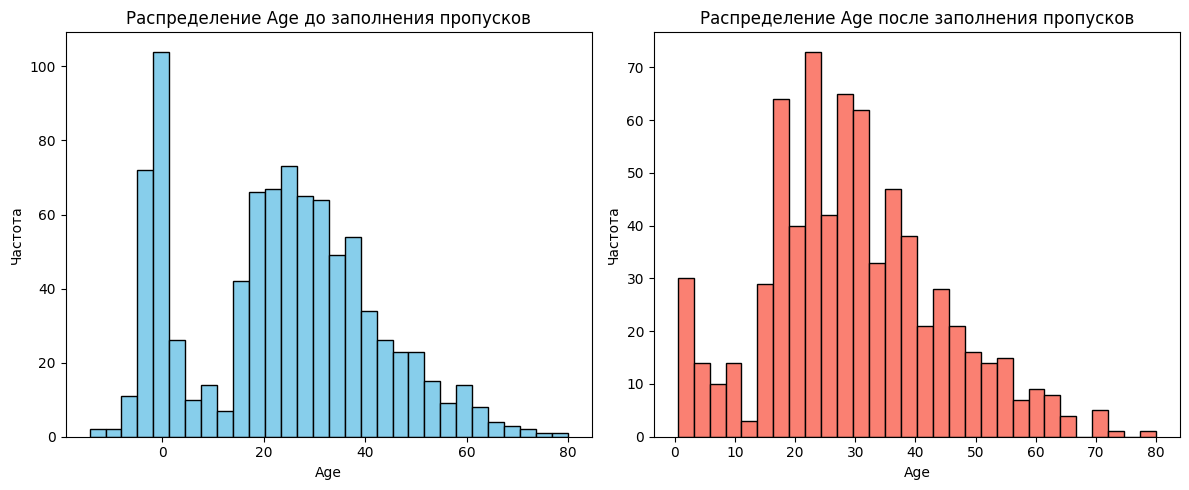

In [39]:
age_before = df['Age']
age_after = combined_original_scale['Age']
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(age_before.dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение Age до заполнения пропусков')
plt.xlabel('Age')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
plt.hist(age_after, bins=30, color='salmon', edgecolor='black')
plt.title('Распределение Age после заполнения пропусков')
plt.xlabel('Age')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

## Задания для самостоятельного выполнения
1. Сделайте копию датафрейма df и выведите информацию о нём.
2. Заполните пропуски в столбце Age, проделав аналогичные действия, но вместо модели линейной регрессии используйте модель KNeighborsRegressor.
3. Снова сделайте копию датафрейма df.
2. Произведите масштабирование данных, выполнив стандартную нормализацию. Представьте результат в виде датафрейма, добавив названия колонок.
2. Создайте объект класса KNNImputer с пятью соседями и однаковым весом для каждого из них (n_neighbors = 5, weights = 'uniform' стоят по умолчанию).
3. Заполните пропуски в столбце Age, обучив и трансформировав созданную модель на масштабированном датасете. Представьте результат в виде датафрейма, добавив названия колонок.
4. Верните данным исходный масштаб при помощи метода .inverse_transform(). Представьте результат в виде датафрейма, добавив названия колонок. 
5. Округлите в получившемся датафрейме значение возраста до одного знака после запятой и выведите первые 10 строк этого датафрейма. Убедитесь, что пропусков в данных больше нет.
7. Постройте гистограмму распределения признака Age после заполнения пропусков. Выведите среднее и медианное значения для признака Age.
8. Сравните методы заполнения пропусков при помощи линейной регрессии и KNNImputer. Для этого обучите модель логистической регрессии на данных с заполненными пропусками первым и вторым методами, предварительно масштабировав их. Возьмите целевую переменную Survived из исходного файла. Выведите значение accuracy для каждого случая и сравните их значения между собой.

In [40]:
df_copy = df.copy()

In [41]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [42]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
Test.loc[:, 'Age'] = y_pred_knn

In [43]:
print(Test[['Age']].head())

         Age
5  -0.006828
17  0.296279
19  0.378945
26  0.530498
28  0.434055


In [44]:
df_copy = df.copy()

In [45]:
numeric_cols = df_copy.select_dtypes(include=['number']).columns
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_copy[numeric_cols])
df_scaled = pd.DataFrame(scaled_array, columns=numeric_cols, index=df_copy.index)

In [46]:
df_scaled.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,-1.730108,0.827377,0.737695,-0.070518,0.432793,-0.473674,-0.502445
1,-1.726220,-1.566107,-1.355574,0.803220,0.432793,-0.473674,0.786845
2,-1.722332,0.827377,-1.355574,0.147917,-0.474545,-0.473674,-0.488854
3,-1.718444,-1.566107,-1.355574,0.639394,0.432793,-0.473674,0.420730
4,-1.714556,0.827377,0.737695,0.639394,-0.474545,-0.473674,-0.486337


In [47]:
imputer = KNNImputer()

In [48]:
df_imputed_array = imputer.fit_transform(df_scaled)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_scaled.columns, index=df_scaled.index)

In [49]:
df_imputed.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [50]:
df_imputed.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,-1.730108,0.827377,0.737695,-0.070518,0.432793,-0.473674,-0.502445
1,-1.726220,-1.566107,-1.355574,0.803220,0.432793,-0.473674,0.786845
2,-1.722332,0.827377,-1.355574,0.147917,-0.474545,-0.473674,-0.488854
3,-1.718444,-1.566107,-1.355574,0.639394,0.432793,-0.473674,0.420730
4,-1.714556,0.827377,0.737695,0.639394,-0.474545,-0.473674,-0.486337


In [51]:
df_original_scale_array = scaler.inverse_transform(df_imputed)
df_original_scale = pd.DataFrame(df_original_scale_array, 
                                 columns=df_imputed.columns, 
                                 index=df_imputed.index)

In [52]:
df_original_scale.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [53]:
df_original_scale.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,1.0,3.0,1.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,0.0,38.0,1.0,0.0,71.2833
2,3.0,3.0,0.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,0.0,35.0,1.0,0.0,53.1000
4,5.0,3.0,1.0,35.0,0.0,0.0,8.0500


In [67]:
df_original_scale['Age'] = df_original_scale['Age'].round(1)
missing_values = df_original_scale.isnull().sum().sum()

In [68]:
df_original_scale.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,1.0,3.0,1.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,0.0,38.0,1.0,0.0,71.2833
2,3.0,3.0,0.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,0.0,35.0,1.0,0.0,53.1000
4,5.0,3.0,1.0,35.0,0.0,0.0,8.0500
5,6.0,3.0,1.0,-2.0,0.0,0.0,8.4583
6,7.0,1.0,1.0,54.0,0.0,0.0,51.8625
7,8.0,3.0,1.0,2.0,3.0,1.0,21.0750
8,9.0,3.0,0.0,27.0,0.0,2.0,11.1333
9,10.0,2.0,0.0,14.0,1.0,0.0,30.0708


In [56]:
missing_values

0

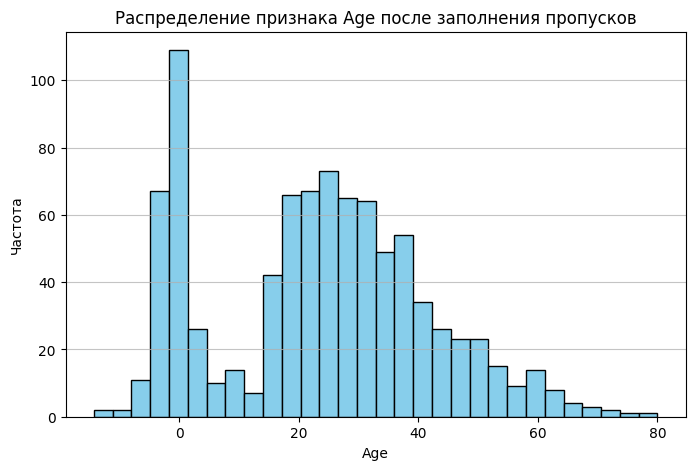

Среднее значение Age: 23.29
Медианное значение Age: 24.00


In [60]:
plt.figure(figsize=(8, 5))
plt.hist(df_original_scale['Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение признака Age после заполнения пропусков')
plt.xlabel('Age')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()
mean_age = df_original_scale['Age'].mean()
median_age = df_original_scale['Age'].median()
print(f"Среднее значение Age: {mean_age:.2f}")
print(f"Медианное значение Age: {median_age:.2f}")